In [1]:
import matplotlib.pyplot as plt

import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import csv
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import psutil
import matplotlib.pyplot as plt

def get_memory_usage():
    process = psutil.Process()
    memory_info = process.memory_info()
    return memory_info.rss  # return physical memory occupency
def normalize_list(input_list):
    min_val = min(input_list)
    max_val = max(input_list)
    if max_val - min_val != 0:
        normalized_list = [(x - min_val) / (max_val - min_val) for x in input_list]
    elif max_val == 0: normalized_list = np.array(input_list)
    else: normalized_list = np.array(input_list)/max_val
    return normalized_list
def remap_value(value, input_range, output_range):
    # map `value` from `input_range` to `output_range`
    input_min, input_max = input_range
    output_min, output_max = output_range

    mapped_value = (value - input_min) / (input_max - input_min) * (output_max - output_min) + output_min
    return mapped_value

def custom_remap(value):
    if value > 0 and value<0.2:
        return remap_value(value, (0, 0.2), (0, 0.1))
    return value
counts = 0

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2000, 900), 
            nn.ReLU(),  # ReLU activation function
            nn.Linear(900,250),
            nn.ReLU(),
            nn.Linear(250,50),
            nn.ReLU(),
            nn.Linear(50, 2) 
        )

    def forward(self, inputs):
        outputs = self.fc(inputs)
        return outputs

In [2]:
data_set = {'trmnn': {'G0':0,'G1':0,'E0':0,'E1':0,'0G':0,'0E':0,'1G':0,'1E':0}, 'fnn': {'G0':0,'G1':0,'E0':0,'E1':0,'0G':0,'0E':0,'1G':0,'1E':0}}

# Test

## Define test function

In [9]:
label2out = {'excited':1, 'ground':0}

def test_trmnn(model, testloader, test_label):
    if test_label in label2out.keys(): out_val = label2out[test_label]
    else: out_val = 0.5
    running_acc = 0.
    list=[]
    lens=0
    for (inputs, labels) in testloader:
        outputs = model(inputs)
        outputs = torch.softmax(outputs, 1)
        result, predict = torch.max(outputs,1)
        list.append(outputs[:,1].item())
        # list.append(result.item())
        list.append(predict.item())
        if labels.item() ==out_val and predict.item()==out_val:
            correct_num = (predict == labels).sum()
            running_acc += correct_num.item()
            lens=lens+1
    running_acc /= 2000 
    return running_acc*100,list

def test_fnn(model, testloader, test_label):
    if test_label in label2out.keys(): out_val = label2out[test_label]
    else: out_val = 0.5
    running_acc = 0.
    list=[]
    lens=0
    for (inputs, labels) in testloader:
        outputs = model(inputs)
        outputs = torch.softmax(outputs, 1)
        result, predict = torch.max(outputs, 1)
        list.append(outputs[:,1].item())
        if labels.item() ==out_val and predict.item()==out_val:
            correct_num = (predict == labels).sum()
            running_acc += correct_num.item()
            lens=lens+1
    running_acc /= 2000
    return running_acc*100,list

## Load test set

In [10]:
pth = 'Data/crosstalk_240625/test/'

convert_dict = {'HF': {'ground': 'G', 'excited': 'E'}, 'LF': {'ground': '0', 'excited': '1'}}
another_q_dict = {'HF': 'LF', 'LF': 'HF'}; another_q_condition_dict = {'wc': 'excited', 'c': 'ground'}
## Notice that, the time represents the number average per point in a 200 ns Rabi 
## population vs. time sequence. The standard form for a rabi data is taken for 200ns, 40 population points, and total number of used IQ data groups are 40*time
## Here, the IQ data point per test_label is 1000, therefore the maximum of time is 25

# 'wc': without crosstalk
# 'c': crosstalk
time=50; test_label = ['LF' ,'excited', 'c']
another_q = another_q_dict[test_label[0]]; another_q_condition = another_q_condition_dict[test_label[2]]
q1q2_label = convert_dict[test_label[0]][test_label[1]] + convert_dict[another_q][another_q_condition]

test_filenmae = [test_label[0] + '/' + test_label[0]+'_'+ test_label[2] +'_'+test_label[1]+'.csv']; test_lst = []
for filename in test_filenmae:
    test_lst.append(pd.read_csv(pth+filename, header=None))
test_data=pd.concat(test_lst)

X_test = test_data.iloc[0:40*time,0:2000].to_numpy().astype(float) # 0:2000 means data set size is 2000
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
if test_label[1]=='ground': Y_test_tensor = torch.zeros(time*40,dtype=torch.long).reshape((time*40,1))
elif test_label[1]=='excited': Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
else: Y_test_tensor = torch.ones(time*40,dtype=torch.long).reshape((time*40,1))
testset = TensorDataset(X_test_tensor, Y_test_tensor)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

## Run test and plot

### Single test

Test accuracy
TRMNN: 100.0%
FNN: 100.0%
(Mean, var) of ['LF', 'excited', 'c'] result are:
TRMNN: (0.9733293594566487, 0.024318131079024148)
FNN: (0.9733698903906299, 0.024319702279612446)


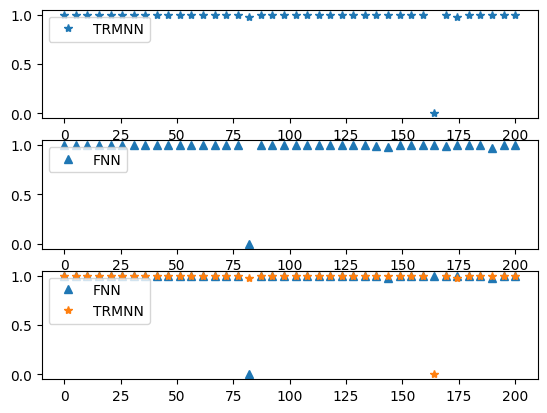

In [11]:
pth = 'Data/tomo_train_240608/train/trained_result/'
if test_label[0] == 'LF':
    mlp_model = torch.load(pth+'mlp_LF_5.pkl')
else:
    mlp_model = torch.load(pth+'mlp_HF_4.pkl')

test_accuracy_trmnn, trnmm_list = test_trmnn(mlp_model, testloader, test_label[1])
test_accuracy_fnn, fnn_list = test_fnn(mlp_model, testloader, test_label[1])

print("Test accuracy")
print(f'TRMNN: {test_accuracy_trmnn}%')
print(f'FNN: {test_accuracy_fnn}%')

result_trmnn = np.zeros(40,dtype= float)
for i in range(len(trnmm_list)):
    result_trmnn[i%40]=result_trmnn[i%40]+trnmm_list[i]
result_trmnn/time
result_trmnn =normalize_list(result_trmnn)

result_fnn = np.zeros(40,dtype= float)
for i in range(len(fnn_list)):
    result_fnn[i%40]=result_fnn[i%40]+fnn_list[i]
result_fnn/time
result_fnn =normalize_list(result_fnn)


print(f'(Mean, var) of {test_label} result are:')
print(f'TRMNN: ({np.average(result_trmnn)}, {np.var(result_trmnn)})')
print(f'FNN: ({np.average(result_fnn)}, {np.var(result_fnn)})')

x=np.linspace(0,200,len(result_fnn))
plt.figure(555)

plt.subplot(3,1,1)
plt.plot(x,result_trmnn,'*',linewidth =0.5,label='TRMNN')
plt.legend()

plt.subplot(3,1,2)
plt.plot(x,result_fnn,'^',linewidth =0.5,label='FNN')
plt.legend()

plt.subplot(3,1,3)
plt.plot(x,result_fnn,'^',linewidth =0.5,label='FNN')
plt.plot(x,result_trmnn,'*',linewidth =0.5,label='TRMNN')
plt.legend()
plt.show()

if test_label[1]=='ground':
    r_trmnn = 1-np.average(result_trmnn)
    r_fnn = 1-np.average(result_fnn)
else:
    r_trmnn = np.average(result_trmnn)
    r_fnn = np.average(result_fnn)

data_set['trmnn'][q1q2_label]= r_trmnn
data_set['fnn'][q1q2_label] = r_fnn

In [318]:
data_set

{'trmnn': {'G0': 0.9723872524199332,
  'G1': 0.9700150090082575,
  'E0': 0.9749475881620718,
  'E1': 0.9749045206178746,
  '0G': 0.9641690256327785,
  '0E': 0.9619684409492557,
  '1G': 0.9733293594566487,
  '1E': 0.9729409377962751},
 'fnn': {'G0': 0.9723872526178237,
  'G1': 0.9700147770109491,
  'E0': 0.9749475881620716,
  'E1': 0.9749045206178746,
  '0G': 0.9641690294684133,
  '0E': 0.9619684448370585,
  '1G': 0.9733698903906299,
  '1E': 0.9733061071833603}}

In [317]:
data_set={'trmnn': {
  'G0': 0.9723872524199332,
  'G1': 0.9700150090082575,
  'E0': 0.9749475881620718,
  'E1': 0.9749045206178746,
  '0G': 0.9641690256327785,
  '0E': 0.9619684409492557,
  '1G': 0.9733293594566487,
  '1E': 0.9729409377962751,
  },
 'fnn': {
  'G0': 0.9723872526178237,
  'G1': 0.9700147770109491,
  'E0': 0.9749475881620716,
  'E1': 0.9749045206178746,
  '0G': 0.9641690294684133,
  '0E': 0.9619684448370585,
  '1G': 0.9733698903906299,
  '1E': 0.9733061071833603,
  }}

In [319]:
import pickle

pickle.dump(data_set, open('data_set.pkl', 'wb'))

## Data processing

In [320]:
def cal_assign_matrix(A,B,C,D,a,b,c,d):
    assign_matrix = np.zeros([4,4])

    assign_matrix[0,0] = A*a
    assign_matrix[0,1] = A*(1-a)
    assign_matrix[0,2] = (1-A)*a
    assign_matrix[0,3] = (1-a)*(1-A)

    assign_matrix[1,0] = B*(1-c)
    assign_matrix[1,1] = B*c
    assign_matrix[1,2] = (1-B)*(1-c)
    assign_matrix[1,3] = (1-B)*c

    assign_matrix[2,0] = (1-C)*b
    assign_matrix[2,1] = (1-C)*(1-b)
    assign_matrix[2,2] = C*b
    assign_matrix[2,3] = C*(1-b)

    assign_matrix[3,0] = (1-D)*(1-d)
    assign_matrix[3,1] = (1-D)*d
    assign_matrix[3,2] = D*(1-d)
    assign_matrix[3,3] = D*d

    return assign_matrix
    

### For TRMNN

In [321]:
process_matrix_dict = {}
net_list = ['trmnn', 'fnn']
for keys in net_list:
    dd = data_set[keys]
    A = dd['G0']
    B = dd['G1']
    C = dd['E0']
    D = dd['E1']
    a = dd['0G']
    b = dd['0E']
    c = dd['1G']
    d = dd['1E']
    process_matrix_dict[keys] = cal_assign_matrix(A,B,C,D,a,b,c,d)
    

In [322]:
import pickle
pickle.dump(process_matrix_dict, open('process_matrix_dict.pkl', 'wb'))
process_matrix_dict

{'trmnn': array([[9.37545670e-01, 3.48415827e-02, 2.66233559e-02, 9.89391651e-04],
        [2.58709216e-02, 9.44144087e-01, 7.99718916e-04, 2.91852721e-02],
        [2.40996296e-02, 9.52782280e-04, 9.37868811e-01, 3.70787768e-02],
        [6.79060138e-04, 2.44164192e-02, 2.63800021e-02, 9.48524519e-01]]),
 'fnn': array([[9.37545674e-01, 3.48415790e-02, 2.66233558e-02, 9.89391538e-04],
        [2.58315998e-02, 9.44183177e-01, 7.98509775e-04, 2.91867132e-02],
        [2.40996297e-02, 9.52782183e-04, 9.37868815e-01, 3.70787730e-02],
        [6.69896037e-04, 2.44255833e-02, 2.60239968e-02, 9.48880524e-01]])}

### TRMNN

In [9]:
d = data_set['trmnn']
which_label = 'LF'
label_set1 = ['ground', 'ground', 'excited', 'excited']
label_set2 = ['ground', 'excited', 'ground', 'excited']
crosstalk_matrix = np.zeros([4,4])

for i,j in enumerate(zip(label_set1, label_set2)):
    for k,l in enumerate(zip(label_set1, label_set2)):
        val = d[which_label][j[0]][l[0]] * d[which_label][j[1]][l[1]]
        crosstalk_matrix[i,k] = val
crosstalk_matrix

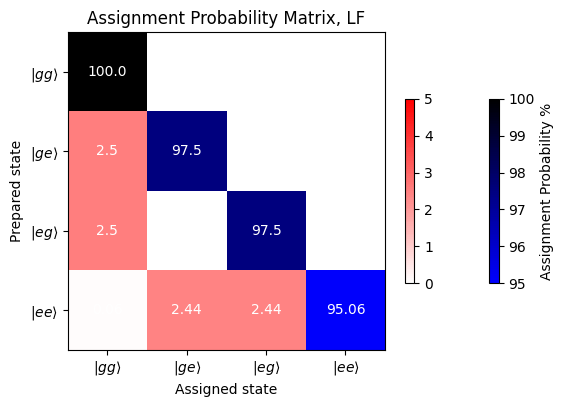

In [32]:
from numpy.ma import masked_array
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm

cmap_high= LinearSegmentedColormap.from_list("mid", ["white", "red"], N=100)
cmap_mid= LinearSegmentedColormap.from_list("high", ["blue", "black"], N=100)

data =crosstalk_matrix* 100
v1a = masked_array(data,data<10)
v1b = masked_array(data,data>=90)
fig,ax = plt.subplots()
pa = ax.imshow(v1a,interpolation='nearest',cmap=cmap_mid, norm=plt.Normalize(95, 100))
cba = plt.colorbar(pa,shrink=0.5)
pb = ax.imshow(v1b,interpolation='nearest',cmap=cmap_high, norm=plt.Normalize(0, 5))
cbb = plt.colorbar(pb,shrink=0.5)

states = [r'$|gg\rangle$', r'$|ge\rangle$', r'$|eg\rangle$', r'$|ee\rangle$']

for i in range(len(states)):
    for j in range(len(states)):
        text = ax.text(j, i, np.round(data[i, j],2),
                       ha="center", va="center", color="w")


ax.set_xticks(np.arange(len(states)))
ax.set_yticks(np.arange(len(states)))
ax.set_xticklabels(states)
ax.set_yticklabels(states)

plt.title(f'Assignment Probability Matrix, {which_label}')
ax.set_xlabel('Assigned state')
ax.set_ylabel('Prepared state')
cba.set_label('Assignment Probability %')
plt.show()

In [61]:
label_set1 = ['ground', 'ground', 'excited', 'excited']
label_set2 = ['ground', 'excited', 'ground', 'excited']

In [62]:
for i,j in enumerate(zip(label_set1, label_set2)):
    print(i,j)

0 ('ground', 'ground')
1 ('ground', 'excited')
2 ('excited', 'ground')
3 ('excited', 'excited')
